In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
np.set_printoptions(suppress=True)

## Load all the Dataset Data

In [2]:
import os
import json

PRE_PROCESS_DATA_FOLDER = "pre_processed_data"

In [3]:
def infer_column_type(column:pd.Series):
    try:
        column = pd.to_numeric(column)
    except:
        print("Failed cast to a numeric type.")
    if column[0] == "False":
        
         False
    elif column[0] == "True":
        column = True
    column = column.astype(str)
    return column


In [4]:
data_list = []

for file in os.listdir(PRE_PROCESS_DATA_FOLDER):
    if ".json" not in file:
        continue
    with open(os.path.join(PRE_PROCESS_DATA_FOLDER, file), "r") as f:
        load_data = json.load(f)
    data_list.append(pd.Series(list(load_data.values()), index=load_data.keys()))

In [5]:
data = pd.DataFrame(data_list)

In [6]:
data

,worker_id,worker_age,worker_lang,worker_fluency,set_name,set_trials,participant_type,platform_type,vision,target_error,...,trial_9_fixation_target_TRT,pre_question_9_name,pre_question_9_time,question_9_name,question_9_time,question_9_answer,question_9_correct_flag,question_9_target_to_fixation_ratio,set_language,fixation_error
0,A10BH9PYCYUKDJ,42,English,5,mturk_EN_v01,"[meco_para_3, a_ScottishParliament_2, a_Rhine_...",None,None,None,False,...,988.0,q_before_a_VictoriaAustralia_2_qa_0,6849.0,q_after_a_VictoriaAustralia_2_qa_0,4544.0,car,1.0,0.017467,EN,False
1,A10C60VRCFZGDD,57,English,5,mturk_ES_v07,"[meco_para_12, a_Rhine_0, a_Steamengine_0, a_F...",None,None,None,False,...,0.0,q_before_a_Apolloprogram_4_qa_1,1348.0,q_after_a_Apolloprogram_4_qa_1,3815.0,idk,0.0,0.000000,ES,True
2,A10W3EILX06DFO,35,English,5,mturk_EN_v20,"[meco_para_11, a_Steamengine_0, a_Oxygen_1, a_...",None,None,None,False,...,0.0,q_before_a_SkyUnitedKingdom_4_qa_2,6584.0,q_after_a_SkyUnitedKingdom_4_qa_2,17068.0,virgin media,1.0,0.000000,EN,False
3,A11C5FSSHQEQ3E,38,English,5,mturk_EN_v13,"[meco_para_12, a_DoctorWho_4, a_VictoriaAustra...",None,None,None,False,...,0.0,q_before_a_FresnoCalifornia_0_qa_0,1376.0,q_after_a_FresnoCalifornia_0_qa_0,12718.0,southwest Fresno,1.0,0.000000,EN,False
4,A11EZAV2HRYKD5,27,English,4,mturk_DE_v04,"[meco_para_12, a_NikolaTesla_1, a_Universityof...",None,None,None,False,...,302.0,q_before_a_Steamengine_0_qa_1,11302.0,q_after_a_Steamengine_0_qa_1,6177.0,idk,0.0,0.019011,DE,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,p7_lab-control,28,Spanish,4,mturk_EN_v02_lab_cognition,"[meco_para_3, a_Computationalcomplexitytheory_...",lab,cognition,normal,False,...,581.0,q_before_a_DoctorWho_3_qa_0,10387.0,q_after_a_DoctorWho_3_qa_0,4690.0,dudley simpson,1.0,0.500000,EN,False
610,p7_volunteer-cognition,22,Croatian,3,mturk_EN_v02_volunteer_cognition,"[meco_para_3, a_Computationalcomplexitytheory_...",volunteer,cognition,None,False,...,0.0,q_before_a_DoctorWho_3_qa_0,8174.0,q_after_a_DoctorWho_3_qa_0,8135.0,Dudley Simpson,1.0,0.000000,EN,False
611,p7_volunteer-cognition,23,Croatian,2,mturk_EN_v18_cognition_volunteer,"[meco_para_11, a_SuperBowl50_3, a_FrenchandInd...",volunteer,cognition,None,False,...,340.0,q_before_a_SkyUnitedKingdom_1_qa_0,3957.0,q_after_a_SkyUnitedKingdom_1_qa_0,4092.0,1998,1.0,0.045872,EN,False
612,p8-volunteer-cognition,22,Croatian,3,mturk_EN_v02_volunteer_cognition,"[meco_para_3, a_Computationalcomplexitytheory_...",volunteer,cognition,None,False,...,0.0,q_before_a_DoctorWho_3_qa_0,12110.0,q_after_a_DoctorWho_3_qa_0,9516.0,Dudley Simpson,1.0,0.000000,EN,False


In [7]:
# Filters to apply:
approved_only = (data.approved_flag > 0).to_numpy() 
no_fixation_error = (data.fixation_error == False).to_numpy()
no_target_error = (data.target_error == False).to_numpy()
sample_higher_10 = (data.webgazer_sample_rate > 10).to_numpy()
acc_higher = (data.avg_roi_last_val > 0).to_numpy()
filter_mturks = np.array([False if "link" in worker_id else True for worker_id in data["worker_id"]])
filter_sets = np.array([True if set_lang in ["EN", "DE", "ES", "TR"] else False for set_lang in data["set_language"]])
# Set a maximum time to 60 minutes
# "EN", "DE", "ES", "TR"
max_time_min = 60
filter_max_time = (data.exp_total_time < max_time_min/0.000016666).to_numpy()

screen_x_above_1280 = (data.screen_x > 1110).to_numpy() # Some tolerance
screen_y_above_720 = (data.screen_y > 615).to_numpy() # Some Tolerance
screen_above_1280_720 = screen_x_above_1280 & screen_y_above_720

In [8]:
dict_filter = {
    #"filter_mturks" : filter_mturks,
    "filter_sets" : filter_sets,
    "Approved":approved_only,
    "Sample Rate": sample_higher_10,
    "Fix_Error, Target_Error": no_fixation_error & no_target_error,
    "screen_above_1280_720": screen_above_1280_720,
    "acc_thresh": acc_higher,
    f"Maximum time ({max_time_min} min)":filter_max_time
}

In [9]:
n_total = len(data)
current_filter = np.ones(len(data),dtype=bool)
for condition, f in dict_filter.items():
    n_data_filtered = len(data.iloc[~f & current_filter])
    per_cent = n_data_filtered/n_total * 100
    print(f"For condition ({condition}), {per_cent:.2f}% has been filtered. ({n_data_filtered} out of {n_total})")
    current_filter = current_filter & f
    n_total = len(data.iloc[current_filter])

For condition (filter_sets), 0.81% has been filtered. (5 out of 614)
For condition (Approved), 29.23% has been filtered. (178 out of 609)
For condition (Sample Rate), 10.67% has been filtered. (46 out of 431)
For condition (Fix_Error, Target_Error), 4.16% has been filtered. (16 out of 385)
For condition (screen_above_1280_720), 0.27% has been filtered. (1 out of 369)
For condition (acc_thresh), 1.09% has been filtered. (4 out of 368)
For condition (Maximum time (60 min)), 0.82% has been filtered. (3 out of 364)


In [10]:
# Combine filters into a mask
mask = np.ones(data.shape[0], dtype=bool)
for filter_name, filter_mask in dict_filter.items():
    mask = mask & filter_mask

In [11]:
data_filtered = data[mask].copy()
print("Before: ", data.shape, " After: ", data_filtered.shape)

Before:  (614, 153)  After:  (361, 153)


In [12]:
data_filtered[data_filtered.set_language=="EN"].worker_lang.value_counts()

English               125
Croatian               26
Chinese (Mandarin)      2
Italian                 2
Portuguese              2
Spanish                 2
Indonesian              1
Marathi                 1
Swahili                 1
Name: worker_lang, dtype: int64

In [13]:
data_filtered[data_filtered.set_language=="DE"].worker_lang.value_counts()

German        15
English        4
Croatian       1
Portuguese     1
Name: worker_lang, dtype: int64

In [14]:
data_filtered[data_filtered.set_language=="ES"].worker_lang.value_counts()

Spanish               45
English                6
French                 2
Ukrainian              1
Estonian               1
Chinese (Mandarin)     1
Italian                1
Name: worker_lang, dtype: int64

In [15]:
# Load the text settings:
text_settings_all_settings = pd.read_csv("text_token_stats.csv", index_col=0)

In [16]:
data_filtered["question_0_name"]

0       meco_para_3_qa_0
2      meco_para_11_qa_1
5      meco_para_12_qa_0
9       meco_para_3_qa_0
10      meco_para_3_qa_1
             ...        
609     meco_para_3_qa_0
610     meco_para_3_qa_0
611    meco_para_11_qa_2
612     meco_para_3_qa_0
613     meco_para_3_qa_0
Name: question_0_name, Length: 361, dtype: object

In [17]:
USE_TEXT_FEATURES = False
TASK_NAME = "nr"

In [18]:
# Get a vector of Text_TRT, Target_TRT, Fix_Target, Fix_Total, Correct_Flag
data_for_cls_nr = []
data_for_cls_is = []
rows_dropped = 0
for i in range(10):
    for row_i, row in data_filtered.iterrows():
        # Remove rows where there is no fixation on text
        if row[f"trial_{i}_fixation_text_TRT"] == 0:
            assert row[f"trial_{i}_fixation_target_TRT"] == 0
            rows_dropped += 1
            continue
        set_lang = row["set_language"] 
        set_name = row["set_name"]
        worker_id = row["worker_id"]
        trial_name = row[f"trial_{i}_name"]
        target = row[f"question_{i}_name"]
        
        text_features_row = text_settings_all_settings[(text_settings_all_settings["lang"] == set_lang)
                                                        & (text_settings_all_settings["trial_name"] == trial_name)]
        word_sent_avg = text_features_row["sentence_count"].item()
        participant_fix_dict = pd.read_csv(os.path.join("pre_processed_data","fixation_data_per_part",f"{worker_id}_{set_name}_fix_dict.csv"))
        in_span_TRT = []
        out_span_TRT = []
        for ir, fix_row in participant_fix_dict[participant_fix_dict.text_id == trial_name].iterrows():
            if type(fix_row["Span_word_is_in"]) is str:
                if target in fix_row["Span_word_is_in"]:
                    in_span_TRT.append(fix_row["TRT"])
            else:
                out_span_TRT.append(fix_row["TRT"])
        in_span_mean = np.nanmean(np.array(in_span_TRT))
        if np.isnan(in_span_mean):
            in_span_mean = 0
        out_span_mean = np.nanmean(np.array(out_span_TRT))
        if np.isnan(out_span_mean):
            out_span_mean = 0
        data_to_append = row[[
                f"trial_{i}_fixation_text_TRT", 
                f"trial_{i}_fixation_target_TRT", 
                f"trial_{i}_fixation_on_target", 
                f"question_{i}_target_to_fixation_ratio",
                f"trial_{i}_fixation_total",
                #f"trial_{i}_time",
                f"question_{i}_correct_flag"]].to_numpy()
        relative_TRT = row[f"trial_{i}_fixation_target_TRT"] / row[f"trial_{i}_fixation_text_TRT"]
        if USE_TEXT_FEATURES:
            data_to_append = np.hstack(( [
                                    in_span_mean,
                                    out_span_mean,
                                    relative_TRT,
                                    text_features_row["token_count"].item(),
                                    text_features_row["token_avg_length"].item(), 
                                      ], 
                                    data_to_append))
        else:
            data_to_append = np.hstack(( [
                                        in_span_mean,
                                        out_span_mean,
                                        relative_TRT,
                                        ], 
                                        data_to_append))
        # Trials < 5 are Normal Reading
        if i < 5:
            data_for_cls_nr.append(data_to_append)
        # Trials >= 5 are Information Seaking
        else:
            data_for_cls_is.append(data_to_append)
data_for_cls_nr = np.array(data_for_cls_nr)
data_for_cls_is = np.array(data_for_cls_is)

C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))


C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\1663479321.py:30: Ru

In [19]:
rows_dropped, len(data_for_cls_is), len(data_for_cls_nr), len(data_for_cls_is)+len(data_for_cls_nr)

(24, 1783, 1803, 3586)

In [20]:
18/1940

0.009278350515463918

In [21]:
data_for_cls_is[:2]

array([[0.0, 461.72972972972974, 0.027389756231169543, 43812.0, 1200.0,
        11, 0.0306406685, 359, 0],
       [0.0, 176.77551020408163, 0.03033515452988665, 12263.0, 372.0, 4,
        0.0173913043, 230, 0]], dtype=object)

In [22]:
if TASK_NAME == "nr":
    data_for_classifier = np.array(data_for_cls_nr,dtype=float)
else:
    data_for_classifier = np.array(data_for_cls_is,dtype=float)

In [23]:
all_data = np.vstack((data_for_cls_is,data_for_cls_nr))

In [24]:
print("Information Seeking")
len(data_for_cls_is[data_for_cls_is[:,-1] == 1]), len(data_for_cls_is[data_for_cls_is[:,-1] == 0])

Information Seeking


(1428, 355)

In [25]:
data_for_cls_is[data_for_cls_is[:,-1] == 1][:,-2].mean()

114.34173669467788

In [26]:
data_for_cls_is[data_for_cls_is[:,-1] == 0][:,-2].mean()

161.0112676056338

In [27]:
print("Normal Reading")
len(data_for_cls_nr[data_for_cls_nr[:,-1] == 1]), len(data_for_cls_nr[data_for_cls_nr[:,-1] == 0])

Normal Reading


(1034, 769)

In [28]:
data_for_cls_nr[data_for_cls_nr[:,-1] == 1][:,-2].mean()

231.0164410058027

In [29]:
data_for_cls_nr[data_for_cls_nr[:,-1] == 0][:,-2].mean()

214.36280884265278

In [30]:
data_for_classifier

array([[549.84615385, 567.71641791,   0.11231901, ...,   0.13079019,
        367.        ,   1.        ],
       [  0.        , 102.67741935,   0.        , ...,   0.01149425,
         87.        ,   1.        ],
       [399.        , 141.94      ,   0.04180199, ...,   0.04580153,
        131.        ,   1.        ],
       ...,
       [102.        , 333.20408163,   0.00455683, ...,   0.00552486,
        181.        ,   0.        ],
       [270.        , 284.78787879,   0.01938541, ...,   0.00925926,
        108.        ,   1.        ],
       [270.        , 284.78787879,   0.01938541, ...,   0.00925926,
        108.        ,   1.        ]])

In [31]:
data_for_classifier[0]

array([  549.84615385,   567.71641791,     0.11231901, 63747.        ,
        7160.        ,    48.        ,     0.13079019,   367.        ,
           1.        ])

In [32]:
data_for_classifier[:,:-1]

array([[549.84615385, 567.71641791,   0.11231901, ...,  48.        ,
          0.13079019, 367.        ],
       [  0.        , 102.67741935,   0.        , ...,   1.        ,
          0.01149425,  87.        ],
       [399.        , 141.94      ,   0.04180199, ...,   6.        ,
          0.04580153, 131.        ],
       ...,
       [102.        , 333.20408163,   0.00455683, ...,   1.        ,
          0.00552486, 181.        ],
       [270.        , 284.78787879,   0.01938541, ...,   1.        ,
          0.00925926, 108.        ],
       [270.        , 284.78787879,   0.01938541, ...,   1.        ,
          0.00925926, 108.        ]])

In [33]:
X, y = data_for_classifier[:,:-1], data_for_classifier[:, -1]

In [34]:
X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(X, y, test_size=0.2)

In [35]:
def upscale_dataset(X_train, y_train):
    minority_label = y_train[0]
    count_min_label = (y_train == minority_label).sum()
    for label in np.unique(y_train):
        n_examples = (y_train == label).sum()
        if n_examples < count_min_label:
            minority_label = label

    unbalance_n = (y_train!=minority_label).sum()-(y_train==minority_label).sum()
    indexes_to_add = np.random.choice(X_train[y_train==minority_label].shape[0], size=unbalance_n, replace=True)
    new_X_train = np.vstack((X_train, X_train[indexes_to_add,:]))
    new_y_train = np.hstack((y_train,np.zeros(unbalance_n)))
    balanced_dataset = np.hstack([new_X_train,new_y_train.reshape(-1,1)])
    np.random.shuffle(balanced_dataset)

    return balanced_dataset[:,:-1], balanced_dataset[:,-1]

In [36]:
#from imblearn.over_sampling import SMOTE

In [37]:
#sm = SMOTE()

In [38]:
X_train, y_train = upscale_dataset(X_train_unb, y_train_unb)

In [39]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf = make_pipeline(StandardScaler(), LogisticRegression())
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.54819277, 0.54819277, 0.52409639, 0.52409639, 0.51506024])

In [40]:
scores.mean()

0.5319277108433734

In [41]:
clf.fit(X_train, y_train)
print("Acc Score: ", accuracy_score(y_test_unb, clf.predict(X_test_unb)), 
                    "F1-Score", f1_score(y_test_unb, clf.predict(X_test_unb), average="weighted"))

Acc Score:  0.5650969529085873 F1-Score 0.5649338859232619


In [42]:
(y_test_unb==0).sum()

157

In [43]:
confusion_matrix(y_test_unb, clf.predict(X_test_unb))

array([[ 78,  79],
       [ 78, 126]], dtype=int64)

In [44]:
baseline = DummyClassifier()
baseline.fit(X_train_unb,y_train_unb)

DummyClassifier()

In [45]:
print("Acc Score: ", accuracy_score(y_test_unb, baseline.predict(X_test_unb)),
             "F1-Score", f1_score(y_test_unb, baseline.predict(X_test_unb)))

Acc Score:  0.5650969529085873 F1-Score 0.7221238938053098


In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

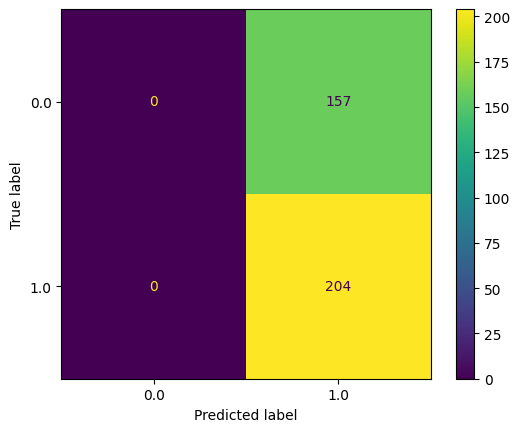

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_unb,baseline.predict(X_test_unb)), display_labels=clf.classes_)
disp.plot()

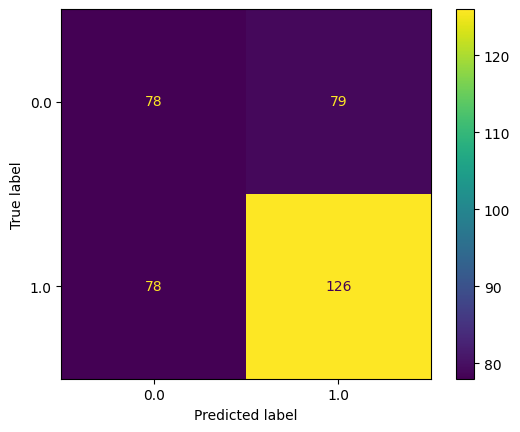

In [48]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_unb, clf.predict(X_test_unb)), display_labels=clf.classes_)
disp.plot()

In [49]:
from sklearn.metrics import classification_report

In [50]:
print(classification_report(y_test_unb, clf.predict(X_test_unb)))

              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50       157
         1.0       0.61      0.62      0.62       204

    accuracy                           0.57       361
   macro avg       0.56      0.56      0.56       361
weighted avg       0.56      0.57      0.56       361



In [51]:
print(classification_report(y_test_unb, baseline.predict(X_test_unb)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       157
         1.0       0.57      1.00      0.72       204

    accuracy                           0.57       361
   macro avg       0.28      0.50      0.36       361
weighted avg       0.32      0.57      0.41       361



c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
classifier_dict = {
    "Baseline (Chance)": DummyClassifier(strategy="uniform"),
    "Majority": DummyClassifier(strategy="prior"),
    "SVM": make_pipeline(StandardScaler(), SVC(gamma='auto')),
    "Log.Reg": make_pipeline(StandardScaler(), LogisticRegression()),
    "Random Forest": RandomForestClassifier(),
    #"MLPClassifier": MLPClassifier(),
}

In [53]:
classifier_results = {
    "Baseline (Chance)": [],
    "Majority": [],
    "SVM": [],
    "Log.Reg": [],
    "Random Forest": [],
    #"MLPClassifier": [],

}

In [54]:
runs = 10

In [55]:
for i in range(runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train_reb, y_train_reb = upscale_dataset(X_train, y_train)
    for clf_name, clf in classifier_dict.items():
        if clf_name == "Majority":
            # Fit data to the original train data
            clf.fit(X_train, y_train)
        else:
            clf.fit(X_train_reb, y_train_reb)
        #print(f"## Results Clf: {clf_name}, seed = {i}")
        preds = clf.predict(X_test)
        acc_score = (y_test == preds).mean()#accuracy_score(y_test, preds, normalize=True)
        f1_sco = f1_score(y_test, preds, average="weighted")
        f1_sco_macro = f1_score(y_test, preds, average="macro")
        #print("Acc Score: ", acc_score , "F1-Score: ", f1_sco)
        classifier_results[clf_name].append((acc_score,f1_sco, f1_sco_macro))

In [56]:
print("Results for task: ", TASK_NAME.upper())
print("Is using text features: ", USE_TEXT_FEATURES)
results_df = pd.DataFrame()
for clf_name, results in classifier_results.items():
    results_row = pd.Series()
    print(f"## Results for {clf_name} ##")
    results = np.array(results)
    print(f"Acc: {results[:,0].mean():.4f} +/- {results[:,0].std():.4f}")
    print(f"F1-Score (Weighted): {results[:,1].mean():.4f} +/- {results[:,1].std():.4f}")
    print(f"F1-Score (Macro): {results[:,2].mean():.4f} +/- {results[:,2].std():.4f}")
    print()
    results_row[f"Acc (mean $n={runs}$)"] = results[:,0].mean()
    results_row[f"Acc (std $n={runs}$)"] = results[:,0].std()
    results_row[f"F1-Score Weighted (mean n={runs})"] = results[:,1].mean()
    results_row[f"F1-Score Weighted (std n={runs})"] = results[:,1].std()
    results_df[clf_name] = results_row

Results for task:  NR
Is using text features:  False
## Results for Baseline (Chance) ##
Acc: 0.4994 +/- 0.0229
F1-Score (Weighted): 0.5014 +/- 0.0239
F1-Score (Macro): 0.4963 +/- 0.0211

## Results for Majority ##
Acc: 0.5623 +/- 0.0252
F1-Score (Weighted): 0.4051 +/- 0.0301
F1-Score (Macro): 0.3598 +/- 0.0102

## Results for SVM ##
Acc: 0.5435 +/- 0.0326
F1-Score (Weighted): 0.5126 +/- 0.0263
F1-Score (Macro): 0.4946 +/- 0.0196

## Results for Log.Reg ##
Acc: 0.5280 +/- 0.0194
F1-Score (Weighted): 0.5193 +/- 0.0224
F1-Score (Macro): 0.5064 +/- 0.0231

## Results for Random Forest ##
Acc: 0.5380 +/- 0.0168
F1-Score (Weighted): 0.5384 +/- 0.0171
F1-Score (Macro): 0.5310 +/- 0.0184



C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_33816\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  re

In [57]:
results_df.T

,Acc (mean $n=10$),Acc (std $n=10$),F1-Score Weighted (mean n=10),F1-Score Weighted (std n=10)
Baseline (Chance),0.499446,0.022878,0.501383,0.023858
Majority,0.562327,0.025206,0.405123,0.030100
SVM,0.543490,0.032584,0.512644,0.026332
Log.Reg,0.527978,0.019359,0.519259,0.022357
Random Forest,0.537950,0.016795,0.538419,0.017125


In [58]:
import warnings

In [62]:
def run_tests_classifier(set_lists=[["EN", "DE", "ES", "TR"]], accuracy_min_list = [0, 20], approved_min_list = [0],
                         list_text_features = [False, True], task_names_list=["nr", "is"]):
    for set_list_selected in set_lists:
        for task_selected in task_names_list:
            for acc_selected in accuracy_min_list:
                for approved_selected in approved_min_list:
                    for text_features_selected in list_text_features:
                        # Filters to apply:
                        approved_only = (data.approved_flag > approved_selected).to_numpy() 
                        no_fixation_error = (data.fixation_error == False).to_numpy()
                        no_target_error = (data.target_error == False).to_numpy()
                        sample_higher_10 = (data.webgazer_sample_rate > 10).to_numpy()
                        acc_higher = (data.avg_roi_last_val > acc_selected).to_numpy()
                        filter_mturks = np.array([False if "link" in worker_id else True for worker_id in data["worker_id"]])
                        filter_sets = np.array([True if set_lang in set_list_selected else False for set_lang in data["set_language"]])
                        # Set a maximum time to 60 minutes
                        # "EN", "DE", "ES", "TR"
                        max_time_min = 60
                        filter_max_time = (data.exp_total_time < max_time_min/0.000016666).to_numpy()

                        screen_x_above_1280 = (data.screen_x > 1110).to_numpy() # Some tolerance
                        screen_y_above_720 = (data.screen_y > 615).to_numpy() # Some Tolerance
                        screen_above_1280_720 = screen_x_above_1280 & screen_y_above_720
                        dict_filter = {
                            #"filter_mturks" : filter_mturks,
                            "filter_sets" : filter_sets,
                            "Approved":approved_only,
                            "Sample Rate": sample_higher_10,
                            "Fix_Error, Target_Error": no_fixation_error & no_target_error,
                            "screen_above_1280_720": screen_above_1280_720,
                            "acc_thresh": acc_higher,
                            f"Maximum time ({max_time_min} min)":filter_max_time
                        }
                        n_total = len(data)
                        current_filter = np.ones(len(data),dtype=bool)
                        for condition, f in dict_filter.items():
                            n_data_filtered = len(data.iloc[~f & current_filter])
                            per_cent = n_data_filtered/n_total * 100
                            print(f"For condition ({condition}), {per_cent:.2f}% has been filtered. ({n_data_filtered} out of {n_total})")
                            current_filter = current_filter & f
                            n_total = len(data.iloc[current_filter])
                        # Combine filters into a mask
                        mask = np.ones(data.shape[0], dtype=bool)
                        for filter_name, filter_mask in dict_filter.items():
                            mask = mask & filter_mask
                        data_filtered = data[mask].copy()
                        print("Before: ", data.shape, " After: ", data_filtered.shape)

                        USE_TEXT_FEATURES = text_features_selected
                        TASK_NAME = task_selected

                        # Get a vector of Text_TRT, Target_TRT, Fix_Target, Fix_Total, Correct_Flag
                        data_for_cls_nr = []
                        data_for_cls_is = []
                        rows_dropped = 0
                        for i in range(10):
                            for row_i, row in data_filtered.iterrows():
                                # Remove rows where there is no fixation on text
                                if row[f"trial_{i}_fixation_text_TRT"] == 0:
                                    assert row[f"trial_{i}_fixation_target_TRT"] == 0
                                    rows_dropped += 1
                                    continue
                                set_lang = row["set_language"] 
                                set_name = row["set_name"]
                                worker_id = row["worker_id"]
                                trial_name = row[f"trial_{i}_name"]
                                target = row[f"question_{i}_name"]
                                
                                text_features_row = text_settings_all_settings[(text_settings_all_settings["lang"] == set_lang)
                                                                                & (text_settings_all_settings["trial_name"] == trial_name)]
                                word_sent_avg = text_features_row["sentence_count"].item()
                                participant_fix_dict = pd.read_csv(os.path.join("pre_processed_data","fixation_data_per_part",f"{worker_id}_{set_name}_fix_dict.csv"))
                                in_span_TRT = []
                                out_span_TRT = []
                                for ir, fix_row in participant_fix_dict[participant_fix_dict.text_id == trial_name].iterrows():
                                    if type(fix_row["Span_word_is_in"]) is str:
                                        if target in fix_row["Span_word_is_in"]:
                                            in_span_TRT.append(fix_row["TRT"])
                                    else:
                                        out_span_TRT.append(fix_row["TRT"])
                                with warnings.catch_warnings():
                                    warnings.simplefilter("ignore", category=RuntimeWarning)
                                    in_span_mean = np.nanmean(np.array(in_span_TRT))
                                    if np.isnan(in_span_mean):
                                        in_span_mean = 0
                                    out_span_mean = np.nanmean(np.array(out_span_TRT))
                                    if np.isnan(out_span_mean):
                                        out_span_mean = 0
                                data_to_append = row[[
                                        f"trial_{i}_fixation_text_TRT", 
                                        f"trial_{i}_fixation_target_TRT", 
                                        f"trial_{i}_fixation_on_target", 
                                        f"question_{i}_target_to_fixation_ratio",
                                        f"trial_{i}_fixation_total",
                                        #f"trial_{i}_time",
                                        f"question_{i}_correct_flag"]].to_numpy()
                                relative_TRT = row[f"trial_{i}_fixation_target_TRT"] / row[f"trial_{i}_fixation_text_TRT"]
                                if USE_TEXT_FEATURES:
                                    data_to_append = np.hstack(( [
                                                            in_span_mean,
                                                            out_span_mean,
                                                            relative_TRT,
                                                            text_features_row["token_count"].item(),
                                                            text_features_row["token_avg_length"].item(), 
                                                            ], 
                                                            data_to_append))
                                else:
                                    data_to_append = np.hstack(( [
                                                                in_span_mean,
                                                                out_span_mean,
                                                                relative_TRT,
                                                                ], 
                                                                data_to_append))
                                # Trials < 5 are Normal Reading
                                if i < 5:
                                    data_for_cls_nr.append(data_to_append)
                                # Trials >= 5 are Information Seaking
                                else:
                                    data_for_cls_is.append(data_to_append)

                        data_for_cls_nr = np.array(data_for_cls_nr)
                        data_for_cls_is = np.array(data_for_cls_is)

                        if TASK_NAME == "nr":
                            data_for_classifier = np.array(data_for_cls_nr,dtype=float)
                        else:
                            data_for_classifier = np.array(data_for_cls_is,dtype=float)

                        X, y = data_for_classifier[:,:-1], data_for_classifier[:, -1]

                        classifier_dict = {
                            "Baseline (Chance)": DummyClassifier(strategy="uniform"),
                            "Majority": DummyClassifier(strategy="prior"),
                            "SVM": make_pipeline(StandardScaler(), SVC(gamma='auto')),
                            "Log.Reg": make_pipeline(StandardScaler(), LogisticRegression()),
                            "Random Forest": RandomForestClassifier(),
                            #"MLPClassifier": MLPClassifier(),
                        }

                        classifier_results = {
                            "Baseline (Chance)": [],
                            "Majority": [],
                            "SVM": [],
                            "Log.Reg": [],
                            "Random Forest": [],
                            #"MLPClassifier": [],

                        }

                        runs = 10
                        for i in range(runs):
                            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
                            X_train_reb, y_train_reb = upscale_dataset(X_train, y_train)
                            for clf_name, clf in classifier_dict.items():
                                if clf_name == "Majority":
                                    # Fit data to the original train data
                                    clf.fit(X_train, y_train)
                                else:
                                    clf.fit(X_train_reb, y_train_reb)
                                #print(f"## Results Clf: {clf_name}, seed = {i}")
                                preds = clf.predict(X_test)
                                acc_score = (y_test == preds).mean()#accuracy_score(y_test, preds, normalize=True)
                                f1_sco = f1_score(y_test, preds, average="weighted")
                                f1_sco_macro = f1_score(y_test, preds, average="macro")
                                #print("Acc Score: ", acc_score , "F1-Score: ", f1_sco)
                                classifier_results[clf_name].append((acc_score,f1_sco, f1_sco_macro))
                                
                        results_df = pd.DataFrame()
                        for clf_name, results in classifier_results.items():
                            results_row = pd.Series(dtype=float)
                            #print(f"## Results for {clf_name} ##")
                            results = np.array(results)
                            #print(f"Acc: {results[:,0].mean():.4f} +/- {results[:,0].std():.4f}")
                            #print(f"F1-Score (Weighted): {results[:,1].mean():.4f} +/- {results[:,1].std():.4f}")
                            #print(f"F1-Score (Macro): {results[:,2].mean():.4f} +/- {results[:,2].std():.4f}")
                            #print()
                            results_row[f"Acc (m n={runs})"] = results[:,0].mean()
                            results_row[f"Acc (s n={runs})"] = results[:,0].std()
                            results_row[f"F1 W (m n={runs})"] = results[:,1].mean()
                            results_row[f"F1 W (s n={runs})"] = results[:,1].std()
                            results_df[clf_name] = results_row
                        print("------------------------------------------------------------------")
                        print("Results for settings: ")
                        print("Sets Selected: ", set_list_selected)
                        print("Accuracy Minimum: ", acc_selected)
                        print("Approved Min: ", approved_selected)
                        print("Results for task: ", TASK_NAME.upper())
                        print("Is using text features: ", USE_TEXT_FEATURES)
                        print(y_train.shape, y_train_reb.shape, y_test.shape)
                        print(results_df.T.round(5))
                        for row_i, row in results_df.T.iterrows():
                            print(f"{row['Acc (m n=10)'].round(2):.2f} ({row['Acc (s n=10)'].round(2):.2f}) & {row['F1 W (m n=10)'].round(2):.2f} ({row['F1 W (s n=10)'].round(2):.2f}) &")
                        print("############################################################")
                        print()

In [60]:
run_tests_classifier(set_lists=[["EN","DE","TR","ES"], ["EN"], ["DE"], ["ES"], ["TR"]])

For condition (filter_sets), 0.81% has been filtered. (5 out of 614)
For condition (Approved), 29.23% has been filtered. (178 out of 609)
For condition (Sample Rate), 10.67% has been filtered. (46 out of 431)
For condition (Fix_Error, Target_Error), 4.16% has been filtered. (16 out of 385)
For condition (screen_above_1280_720), 0.27% has been filtered. (1 out of 369)
For condition (acc_thresh), 1.09% has been filtered. (4 out of 368)
For condition (Maximum time (60 min)), 0.82% has been filtered. (3 out of 364)
Before:  (614, 153)  After:  (361, 153)


------------------------------------------------------------------
Results for settings: 
Sets Selected:  ['EN', 'DE', 'TR', 'ES']
Accuracy Minimum:  0
Approved Min:  0
Results for task:  NR
Is using text features:  False
(1442,) (1650,) (361,)
                   Acc (m n=10)  Acc (s n=10)  F1 W (m n=10)  F1 W (s n=10)
Baseline (Chance)       0.49335       0.02793        0.49539        0.02754
Majority                0.56233       0.02521        0.40512        0.03010
SVM                     0.53546       0.03381        0.51111        0.02462
Log.Reg                 0.52964       0.02550        0.52182        0.02543
Random Forest           0.53269       0.02572        0.53326        0.02538
MLPClassifier           0.51634       0.05281        0.42690        0.08436
0.49 (0.03) & 0.50 (0.03) &
0.56 (0.03) & 0.41 (0.03) &
0.54 (0.03) & 0.51 (0.02) &
0.53 (0.03) & 0.52 (0.03) &
0.53 (0.03) & 0.53 (0.03) &
0.52 (0.05) & 0.43 (0.08) &
#######################################################

KeyboardInterrupt: 

In [65]:
run_tests_classifier(approved_min_list=[0], accuracy_min_list=[0])

For condition (filter_sets), 0.81% has been filtered. (5 out of 614)
For condition (Approved), 29.23% has been filtered. (178 out of 609)
For condition (Sample Rate), 10.67% has been filtered. (46 out of 431)
For condition (Fix_Error, Target_Error), 4.16% has been filtered. (16 out of 385)
For condition (screen_above_1280_720), 0.27% has been filtered. (1 out of 369)
For condition (acc_thresh), 1.09% has been filtered. (4 out of 368)
For condition (Maximum time (60 min)), 0.82% has been filtered. (3 out of 364)
Before:  (614, 153)  After:  (361, 153)
------------------------------------------------------------------
Results for settings: 
Sets Selected:  ['EN', 'DE', 'ES', 'TR']
Accuracy Minimum:  0
Approved Min:  0
Results for task:  NR
Is using text features:  False
(1442,) (1650,) (361,)
                   Acc (m n=10)  Acc (s n=10)  F1 W (m n=10)  F1 W (s n=10)
Baseline (Chance)       0.49640       0.03109        0.49851        0.03189
Majority                0.56233       0.02521 

In [64]:
run_tests_classifier(approved_min_list=[0], accuracy_min_list=[-1])

For condition (filter_sets), 0.81% has been filtered. (5 out of 614)
For condition (Approved), 29.23% has been filtered. (178 out of 609)
For condition (Sample Rate), 10.67% has been filtered. (46 out of 431)
For condition (Fix_Error, Target_Error), 4.16% has been filtered. (16 out of 385)
For condition (screen_above_1280_720), 0.27% has been filtered. (1 out of 369)
For condition (acc_thresh), 0.00% has been filtered. (0 out of 368)
For condition (Maximum time (60 min)), 0.82% has been filtered. (3 out of 368)
Before:  (614, 153)  After:  (365, 153)
------------------------------------------------------------------
Results for settings: 
Sets Selected:  ['EN', 'DE', 'ES', 'TR']
Accuracy Minimum:  -1
Approved Min:  0
Results for task:  NR
Is using text features:  False
(1458,) (1688,) (365,)
                   Acc (m n=10)  Acc (s n=10)  F1 W (m n=10)  F1 W (s n=10)
Baseline (Chance)       0.49699       0.01497        0.49981        0.01457
Majority                0.57452       0.01862